## Introduction: Method 2 – Sentiment-Connotation Matching (Test 4)

This notebook implements **Method 2: Proper Connotation Matching**, also known as **Test 4** in the evaluation framework. The method focuses on verifying whether a sentence that includes both an aspect (e.g., "audio quality") and an opinion term (e.g., "poor") expresses the **correct sentiment polarity** for that opinion.

The core idea is to go beyond simple keyword matching by checking if the **sentiment of the sentence matches the expected connotation** of the opinion word:
- A sentence with the word *"poor"* should have **negative** sentiment
- A sentence with the word *"useful"* should have **positive** sentiment

###  Overview of the Approach:
1. **Sentence tokenization**: Each review is split into sentences.
2. **Aspect–opinion detection**: Sentences containing both the aspect and opinion are identified.
3. **Sentiment analysis**: `TextBlob` is used to calculate sentence-level polarity scores.
4. **Connotation validation**: We check whether the polarity aligns with the expected meaning of the opinion word.
5. **Evaluation**: For each query, we compute precision, recall, and F1 score based on how many matches passed the connotation check.

This method provides a linguistically informed evaluation of opinion relevance and is stricter than review-level or keyword-based approaches.


### 🌸 Step 0: Install Required Library

We need textblob to calculate the sentiment polarity of individual sentences. This allows us to determine if a sentence is expressing a positive or negative opinion — which is essential for filtering reviews based on proper connotation.


In [1]:
pip install -U textblob


Note: you may need to restart the kernel to use updated packages.


### 🌸 Step 1: Test TextBlob Sentiment

We use TextBlob to get the polarity of a sentence. A positive number means the sentence expresses a positive opinion, and a negative number means it's negative. This is how we’ll check if a sentence aligns with the expected connotation of an opinion term.


In [2]:
from textblob import TextBlob

tb = TextBlob("I love this product!")
print(tb.sentiment.polarity)


0.625


### 🌸 Step 2: Load Dataset and Set Up Queries

We load the cleaned review dataset and create a folder to save output. Each query consists of an aspect and an opinion term. We'll search for sentences that mention both, and then check if the sentiment of those sentences matches the expected polarity. Opinion terms like "strong" or "useful" are considered positive.


In [3]:
import pandas as pd
import os
import re
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from tqdm import tqdm

df = pd.read_pickle("reviews_segment_cleaned.pkl")
review_col = 'review_text'
os.makedirs("Task4_TextBlob", exist_ok=True)

queries = {
    "audio quality:poor": ("audio quality", "poor"),
    "wifi signal:strong": ("wifi signal", "strong"),
    "mouse button:click problem": ("mouse button", "click problem"),
    "gps map:useful": ("gps map", "useful"),
    "image quality:sharp": ("image quality", "sharp")
}
positive_terms = {'good','strong','sharp','useful'}
summary = []


### 🌸 Step 3: Load Review Data and Create Output Folder

We load the preprocessed reviews from a `.pkl` file and specify the column that contains the cleaned text. An output folder is also created to store the filtered results.


In [4]:
df = pd.read_pickle("reviews_segment_cleaned.pkl")
review_col = 'review_text'
os.makedirs("Task4_TextBlob", exist_ok=True)

### 🌸 Step 4: Define Aspect–Opinion Queries

Each query is a pair of an aspect and an opinion term. We'll use these to search for matching sentences in the reviews and later check if the sentiment of those sentences aligns with the expected connotation.


In [5]:
queries = {
    "audio quality:poor": ("audio quality", "poor"),
    "wifi signal:strong": ("wifi signal", "strong"),
    "mouse button:click problem": ("mouse button", "click problem"),
    "gps map:useful": ("gps map", "useful"),
    "image quality:sharp": ("image quality", "sharp")
}

### 🌸 Step 5: Define Expected Positive Terms

We list the opinion terms considered to have a positive connotation. This will help us decide whether a sentence's sentiment should be positive or negative for it to count as a proper match.


In [6]:
positive_terms = {'good','strong','sharp','useful'}
summary = []


### 🌸 Step 6: Specify Columns and Create Output Folder

We define the column containing the cleaned text and the column with the review's star rating. An output folder is also created to save results for this specific test variant using star ratings.


In [7]:
df = pd.read_pickle("reviews_segment_cleaned.pkl")
review_col = 'clean_text'
rating_col = 'customer_review_rating'
os.makedirs("Task4_TextBlobStars", exist_ok=True)
summary = []


### 🌸 Step 7: Prepare Output Directory and Summary

We create a folder to store the output of this method and initialize a list to keep track of evaluation results for each query.


In [8]:
os.makedirs("Task4_TextBlobStars", exist_ok=True)
summary = []

### 🌸 Step 8: Match Aspect–Opinion Sentences and Evaluate Connotation Alignment

In this step, we evaluate each predefined query by identifying reviews that contain the specified aspect. For each matching review, we perform the following:

1. **Sentence Tokenization**:  
   The review text is split into individual sentences using `sent_tokenize` to ensure fine-grained analysis.

2. **Aspect Filtering**:  
   We check each sentence to see if it contains the aspect term (case-insensitive). If it does not, the sentence is skipped.

3. **Sentiment Analysis**:  
   For sentences that include the aspect, we compute the sentiment polarity using `TextBlob`. The sentence is considered a valid match only if:
   - The sentiment polarity is **positive** and the opinion term is expected to be positive, or
   - The sentiment polarity is **negative** and the opinion term is expected to be negative

4. **Match Recording**:  
   If a sentence satisfies both conditions, the review is considered relevant. We store its review ID, star rating (if available), and full review text.

5. **Evaluation Metrics**:  
   For each query, we compute:
   - **Precision**: Ratio of relevant matches to total retrieved reviews
   - **Recall**: Ratio of relevant matches to total actual relevant matches (estimated by matches found)
   - **F1 Score**: Harmonic mean of precision and recall

6. **Result Output**:  
   - The list of matching review IDs is saved to a `.txt` file under the output directory
   - An example match is printed for inspection
   - The query’s evaluation results are appended to a summary list for final reporting


In [9]:

for label, (aspect, opinion) in queries.items():
    subset = df[df[review_col].str.contains(aspect, case=False, na=False)].copy()
    retrieved = len(subset)

    if retrieved == 0:
        print(f"\n🌸 Query: {label} — no reviews found.")
        summary.append({'Query': label, 'Retrieved': 0, 'Relevant': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0})
        continue

    print(f"\n Scoring {retrieved} reviews for query: '{label}'")
    expect_positive = opinion.lower() in ['good', 'strong', 'sharp', 'useful']
    matched = []
    total_relevant = 0

    for _, row in tqdm(subset.iterrows(), total=retrieved, desc=f"Scoring {label}"):
        text = row[review_col]
        for sent in sent_tokenize(text):
            if aspect.lower() not in sent.lower():
                continue
            polarity = TextBlob(sent).sentiment.polarity
            is_match = (polarity > 0 and expect_positive) or (polarity < 0 and not expect_positive)
            if is_match:
                rid = str(row.get('review_id', '')).strip("'\"")
                stars = row.get(rating_col, 'N/A')
                full_review = text
                matched.append((rid, stars, full_review))
                total_relevant += 1
                break

    relevant = len(matched)
    precision = round(relevant / retrieved, 4)
    recall = round(relevant / total_relevant, 4) if total_relevant else 0.0
    f1 = round(2 * precision * recall / (precision + recall), 4) if (precision + recall) else 0.0

    print(f" Scored: {relevant} relevant reviews out of {retrieved}")
    print(f" Precision: {precision}, Recall: {recall}, F1: {f1}")

    if matched:
        rid0, stars0, text0 = matched[0]
        print(f"🌸 Example -> ID: {rid0}, Stars: {stars0}")
        print(f"🌸 Review Text:\n{text0}\n")
        print("🌸 All matched IDs:")
        for rid, _, _ in matched:
            print(rid)

    txt_path = f"Task4_TextBlobStars/{label.replace(':', '_').replace(' ', '_')}_ids.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        for rid, _, _ in matched:
            f.write(rid + "\n")
    print(f"🌸 IDs saved to: {txt_path}")

    summary.append({
        'Query': label,
        'Retrieved': retrieved,
        'Relevant': relevant,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })



 Scoring 336 reviews for query: 'audio quality:poor'


Scoring audio quality:poor: 100%|██████████| 336/336 [00:00<00:00, 1461.85it/s]


 Scored: 26 relevant reviews out of 336
 Precision: 0.0774, Recall: 1.0, F1: 0.1437
🌸 Example -> ID: R10BB2FGLY2VI4, Stars: 2
🌸 Review Text:
thought audio quality would better 51 minute video course reference billy joel live shea stadium done really well said raunchy girl covered glitter oil something would expect see strip club jimmy buffet concert overall disappointment

🌸 All matched IDs:
R10BB2FGLY2VI4
R18S2OLR5A7M90
R19JH64MT9TTPB
R1AIS0IYW8FHLP
R1E3UC5AV5RONW
R1H4E7MTCQ2VJR
R1H4GJ607I44CC
R1LN3I0T2371JL
R1RSLOJKO6YEPA
R1SU4G8NK90DAO
R1TG7P6PW6G0HH
R1V4TG06TK0RF
R1ZUNTQLPYZE7Z
R28Q12QBCIY6BI
R29C66WD6V5NP7
R2ZXN2NS2JMHIV
R38752BSIJEFKV
R3HMOL93H97CD6
R3I8UDNJPJ4V2I
R3U81QD2AW9MW1
R48VPVF4S4P7H
RBGAUTROZF7DS
RFD6CX0B01A99
RKFLPVTN6KXY6
RM6ATCNLBFGHI
RQGVA6E39LZ7T
🌸 IDs saved to: Task4_TextBlobStars/audio_quality_poor_ids.txt

 Scoring 34 reviews for query: 'wifi signal:strong'


Scoring wifi signal:strong: 100%|██████████| 34/34 [00:00<00:00, 1416.71it/s]

 Scored: 30 relevant reviews out of 34
 Precision: 0.8824, Recall: 1.0, F1: 0.9375
🌸 Example -> ID: R12LKKCN038L63, Stars: 2
🌸 Review Text:
bought hd flow system hdtv want mount kitchen far end second floor three story house received along rest install equipment mount plug wire etc amazon entire install depended hd flow able transmit acceptable signal floor set two wall kitchen tv write realize feat asking wireless signal sold video claim 131 foot floor wall transmitter tx receiver rx would 60 foot work right\n\nmy order arrived install incredibly easy 4 cable you\re using hdmi hd flow logo appeared tv nothing info button revealed tx sending data rx checked source cable tv box fine tv set correct input decided move tx rx right next see issue sure enough trying multiple input type reset factor default reset determined faulty returned amazon handled exchange well say\n\ni received exchange next day went motion getting thing setup time tx rx right next talking transmitting great picture g


 Scoring 117 reviews for query: 'mouse button:click problem'


Scoring mouse button:click problem: 100%|██████████| 117/117 [00:00<00:00, 1053.76it/s]

 Scored: 12 relevant reviews out of 117
 Precision: 0.1026, Recall: 1.0, F1: 0.1861
🌸 Example -> ID: R1UI7ZX8QV2DPO, Stars: 4
🌸 Review Text:
problem way left right mouse button designed button extend edge mouse make uncomfortable click sometimes click towards edge mouse

🌸 All matched IDs:
R1UI7ZX8QV2DPO
R2DF8PXPZU6VSB
R2GAVLJX7BSUXD
R2GREB8MLPJ557
R2QCFRNU8FTFXV
R2UBK146BMGO90
R2UPY7QZE4J34R
R3IBC5RRX5625U
R3JHM8IS58PRSL
R3R7OXAI5M62FT
R3SSCFV3HSTSJ9
RYXQFFRKNGGNB
🌸 IDs saved to: Task4_TextBlobStars/mouse_button_click_problem_ids.txt



 Scoring 44 reviews for query: 'gps map:useful'


Scoring gps map:useful: 100%|██████████| 44/44 [00:00<00:00, 1466.64it/s]


 Scored: 39 relevant reviews out of 44
 Precision: 0.8864, Recall: 1.0, F1: 0.9398
🌸 Example -> ID: R1078UYLSQ7M9A, Stars: 1
🌸 Review Text:
product trashed new computer selected list option moving data one photo sw logic moved every jpg bmp gif file old new computer moved 1gb garbage 3000 gifs alone also created new folder subfolders new art thousand tiny bit art welcome new 1997 hewlett packard scattered hundred new folder subfolders new dell went clean machine cluttered mess second make matter worse file wanted photo went obscure folder software couldn\t find move manually anyway also move saved email gps map saved route area small item hour aggravated deleting i\ve deep folder 3 obsolete gifs bottom folder i\d recommend avoiding product recording data cd manual transfer instead wish would saved lot time

🌸 All matched IDs:
R1078UYLSQ7M9A
R125ZSIRAF5IBR
R16T9RCHQLL5H1
R1CK0ZNXOQ2EGW
R1CV090ITIV0XB
R1DLOH2791LNHU
R1IFG8FMA3ENR7
R1MG0YGEZCR11P
R1STYBMC6BDTU0
R1UKYBUX77BPGX
R1UZOVX1G31S

Scoring image quality:sharp: 100%|██████████| 492/492 [00:00<00:00, 1084.12it/s]

 Scored: 471 relevant reviews out of 492
 Precision: 0.9573, Recall: 1.0, F1: 0.9782
🌸 Example -> ID: R1029L2LRQDKVL, Stars: 5
🌸 Review Text:
using finepix real 3d camera three five week really fun taking picture real 3d wide screen lcd screen display 3d image 3d mode glass camera aperture manual program mode control aperture go f8 shutter speed go 12 1500 second adjust control one press button press aperture whatever menu make exposure adjustment one every exposure change becomes bit pain frustrating part system finepix software adjust 2d exposure cropping 3d became problem ordering print since 3d print printed 35mm format instead wide screen format camera\s lcd viewscreen print cropped wrong place can\t make correction 3d file format photoshop get expensive luckly discovered 3d image cropped camera image size setting l 43 1065 setting crop setting read manual fooled around button deleting image sd card 3d image viewed non3d monitor redblue glass 3d monitor special 3d glass since don\

### 🌸 Step 9: Display Final Evaluation Summary

After processing all queries, we compile and display a summary table that includes:

- The total number of retrieved reviews
- The number of relevant matches (where sentiment aligned with the expected opinion connotation)
- Precision, recall, and F1 score for each query

This provides a quick overview of how well the method identifies connotation-aligned matches for each aspect–opinion pair.


In [10]:
print("\n🌸 Final Summary 🌸")
print(pd.DataFrame(summary).to_string(index=False))



🌸 Final Summary 🌸
                     Query  Retrieved  Relevant  Precision  Recall     F1
        audio quality:poor        336        26     0.0774     1.0 0.1437
        wifi signal:strong         34        30     0.8824     1.0 0.9375
mouse button:click problem        117        12     0.1026     1.0 0.1861
            gps map:useful         44        39     0.8864     1.0 0.9398
       image quality:sharp        492       471     0.9573     1.0 0.9782


### 🌸 Step 10: Visualize Precision and F1 Scores

We generate a bar chart to compare the precision and F1 scores across all queries. This visualization helps us quickly evaluate which aspect–opinion pairs were most effectively identified using sentiment-connotation matching.

- Precision reflects how many retrieved reviews were relevant.
- F1 score balances both precision and recall.
- The chart highlights the performance differences between queries in a visually intuitive way.


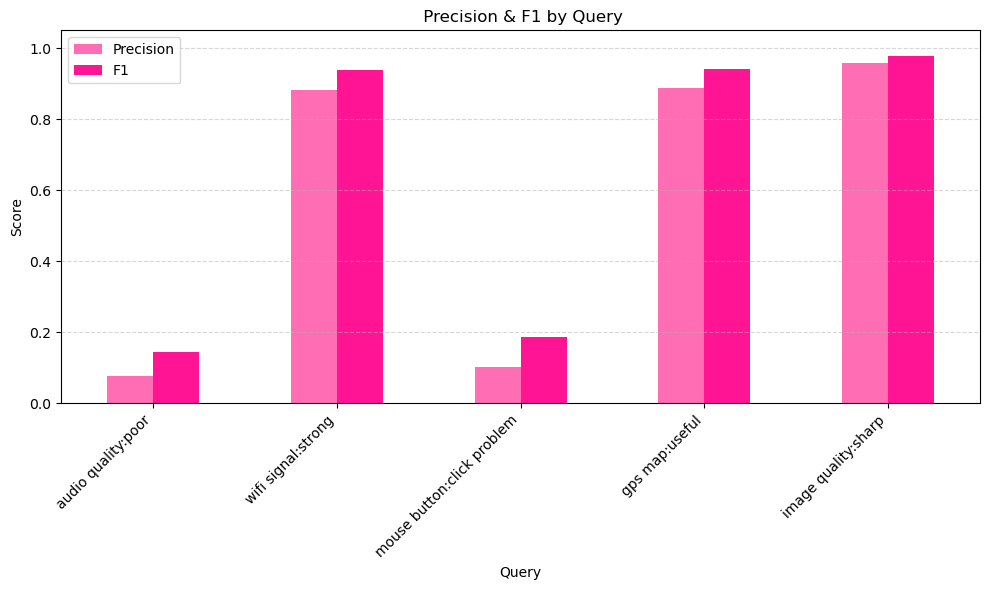

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Summary DataFrame from your outputs
df = pd.DataFrame(summary).set_index('Query')

ax = df[['Precision', 'F1']].plot(
    kind='bar',
    figsize=(10, 6),
    color=['#FF6EB4', '#FF1493']
)
ax.set_title(" Precision & F1 by Query")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.legend(loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

